# *Overfit* y *underfit*

## Objetivos
- Comprender qué son y por qué se producen fenómenos como el *overfitting* y el *underfitting*.
- Conocer diferentes técnicas que favorecen que nuestro modelo generalice mejor.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import numpy as np
import pandas as pd
from IPython import display
from matplotlib import pyplot as plt

import os

print(tf.__version__)

2.18.0


## Base de datos Wine Quality

Esta base de datos consta de mediciones fisicoquímicas de unos 1.600 vinos tintos portugueses, junto con una calificación de la calidad de cada vino recogida por medio de catas a ciegas. ¿Es posible predecir la calidad del vino a partir de estas mediciones?

La base de datos es de acceso libre desde el [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/186/wine+quality).

In [2]:
data_path = os.getcwd() 
data_path += '\\winequality-red.csv'
red_wine = pd.read_csv(data_path, sep=';')
red_wine.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5
1598,6.0,0.310,0.47,3.6,0.067,18.0,42.0,0.99549,3.39,0.66,11.0,6


## Pretratamiento de datos

Como hemos visto en el primer ejemplo, antes de comenzar con el entrenamiento del modelo hay que acondicionar los datos de forma adecuada. Para ello, seguimos los siguientes pasos:
1. Dividir los datos (70% training - 30% validación). No vamos a considerar test set en esta ocasión.
2. Escalado de datos, de nuevo, utilizando *min-max normalization*.
3. Separar las variables de entrada o *inputs* de las variables de salida o *outputs*.

In [31]:
# Split data
train_ratio = 0.7  
df_train = red_wine.sample(frac=train_ratio, random_state=0)
df_valid = red_wine.drop(df_train.index)

# Split features and target
X_train = df_train.drop('quality', axis=1)
X_valid = df_valid.drop('quality', axis=1)
y_train = df_train['quality']
y_valid = df_valid['quality']

# Scale to [0, 1]
max_ = X_train.max(axis=0)
min_ = X_train.min(axis=0)
X_train = (X_train - min_) / (max_ - min_)
X_valid = (X_valid - min_) / (max_ - min_)

## Demostrar *overfiting* y *underfiting*
En esta sección vamos a entrenar diferentes configuraciones o arquitecturas de redes neuronales siguiendo el mismo procedimiento de entrenamiento para poder comparar las diferencias entre ellas.

### Definir los modelos

La capacidad de un modelo se refiere al tamaño y la complejidad de los patrones que es capaz de aprender. En el caso de las redes neuronales, depende del número de neuronas que tenga y de cómo estén conectadas entre sí. Por tanto, si parece que una red no se ajusta bien a los datos, se debe aumentar su capacidad.

Hay dos maneras de aumentar la capacidad de una red neuronal:
- Haciendo la red más ancha (añadiendo más neuronas a las capas existentes).
- Haciendo la red más profunda (añadiendo más capas). 

A las redes más anchas les resulta más fácil aprender relaciones  lineales, mientras que las redes más profundas prefieren las no lineales.

In [32]:
small = keras.Sequential([
    layers.Input(shape=[X_train.shape[1]]),
    layers.Dense(16, activation='relu'),
    layers.Dense(1),
])

wider = keras.Sequential([
    layers.Input(shape=[X_train.shape[1]]),
    layers.Dense(32, activation='relu'),
    layers.Dense(1),
])

deeper = keras.Sequential([
    layers.Input(shape=[X_train.shape[1]]),
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1),
])

large = keras.Sequential([
    layers.Input(shape=[X_train.shape[1]]),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)])

### Establecer un método de entrenamiento común

Como se va a emplear la misma configuración para los comandos `compile` y `fit` y, además, se va a aplicar a los diferentes modelos, resulta conveniente agrupar todo este proceso en una función que llamaremos `compile_and_fit`.

In [33]:
EPOCHS = 200
BATCH_SIZE = 256

In [34]:
def compile_and_fit(model, callback , max_epochs=10000):
  optimizer = tf.keras.optimizers.Adam()
  model.compile(optimizer=optimizer,loss='mae')

  # model.summary()

  history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callback, # put your callbacks in a list
    verbose=0,  # turn off training log
    )

  return history

### Comparar el proceso de entrenamiento

In [35]:
size_histories = {}
size_histories['small'] = compile_and_fit(small, [])
size_histories['wider'] = compile_and_fit(wider, [])
size_histories['deeper'] = compile_and_fit(deeper, [])
size_histories['large'] = compile_and_fit(large, [])

In [36]:
print("Minimum validation loss:")
for model_name, history in size_histories.items():
    print("    - "+model_name+": "+str(min(history.history['val_loss'])))

Minimum validation loss:
    - small: 0.5894041657447815
    - wider: 0.5425727963447571
    - deeper: 0.5016321539878845
    - large: 0.47550496459007263


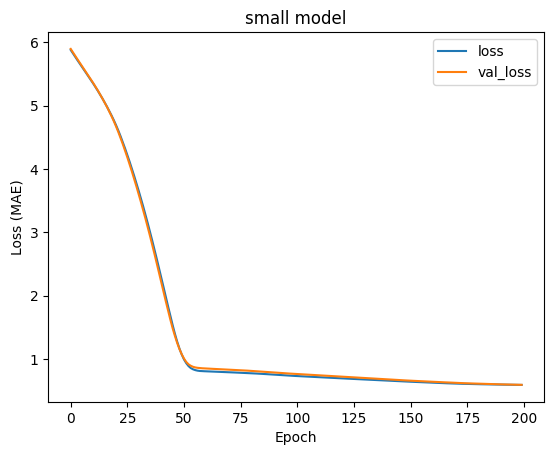

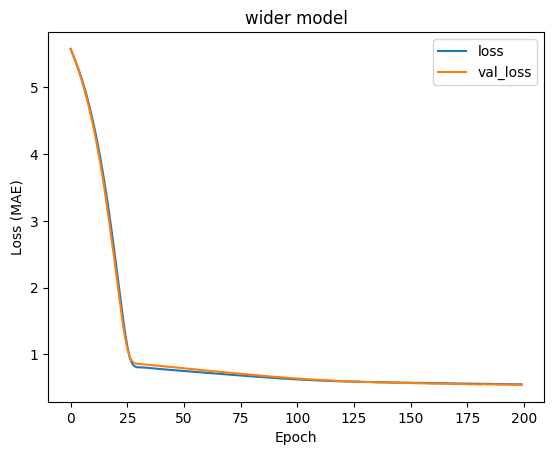

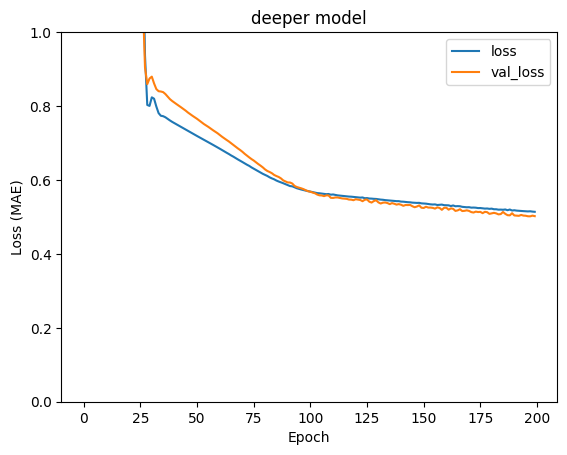

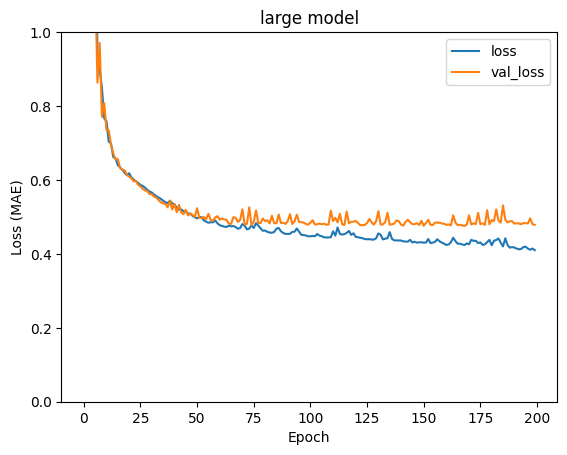

In [44]:
def plot_history(model_name, history, ylim=None):
    history_df = pd.DataFrame(history.history)
    history_df.loc[:, ['loss', 'val_loss']].plot()
    plt.title(model_name+' model')
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MAE)")
    if ylim is not None:
        plt.ylim(ylim)

plot_history('small', size_histories['small'],)
plot_history('wider', size_histories['wider'],)
plot_history('deeper', size_histories['deeper'], [0.,1.])
plot_history('large',size_histories['large'], [0.,1.])

## Técnicas para prevenir el sobreajuste

#### *Early stopping*

Hemos visto que los modelos tienden a aprender inclus el ruido que hay en los datos tratando de ajustarse lo máximo posible a los datos de entrenamiento. Cuando esto ocurre, la *loss function* medida en el set de validación puede comienza a aumentar.

Para evitarlo, podemos detener el entrenamiento cuando parezca que la pérdida de validación ya no disminuye. Interrumpir el entrenamiento de esta forma se denomina *early stopping* y en TensorFlow se implementa por medio de un *callback*. 

Los *callback* son simplemente una función que se ejecutan cada cierto tiempo mientras la red se entrena. El *early stopping* lo hace después de cada época. Tensorflow cuenta con una [variedad de callbacks útiles predefinidos](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks), pero también pueden definirse de forma personalizada.

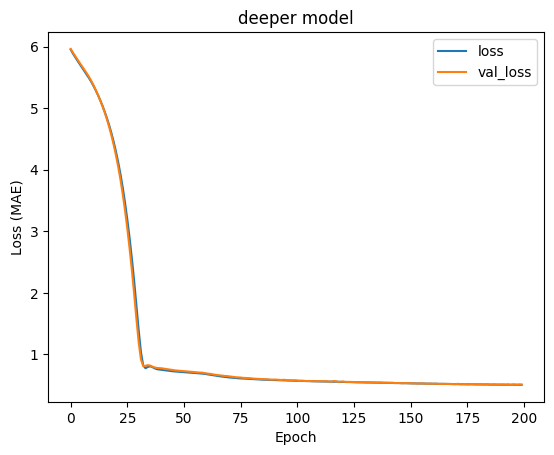

In [45]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor = 'val_loss', # what to monitor
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model = keras.Sequential([
    layers.Input(shape=[X_train.shape[1]]),
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1),
])

history = compile_and_fit(model, [early_stopping])

plot_history('deeper', history)

#### Regularización
Una forma común de mitigar el sobreajuste es forzando a que los pesos tomen valores pequeños. Esto se llama **regularización** y se hace añadiendo a la *loss function* de la red un coste asociado a tener pesos grandes. Este coste puede ser de dos tipos:

* [Regularización L1](https://developers.google.com/machine-learning/glossary/#L1_regularization), donde el coste añadido es proporcional al valor absoluto de los coeficientes de los pesos (es decir, a lo que se denomina la «norma L1» de los pesos).

* [Regularización L2](https://developers.google.com/machine-learning/glossary/#L2_regularization), en la que el coste añadido es proporcional al cuadrado del valor de los coeficientes de las ponderaciones (es decir, a lo que se denomina la «norma L2» al cuadrado de los pesos).

La regularización L1 fomenta que los pesos tomen el valor de 0 exactamente mientras que la regularización L2 penalizará los parámetros de pesos sin hacerlos totalmente 0, ya que la penalización va a cero para pesos pequeños. Es por esto que la L2 es más común en el contexto de redes neuronales, ya que favorece el aprendizaje al reducir el riesgo de *vanishing gradients*.

In [39]:
l2_model = tf.keras.Sequential([
    layers.Input(shape=[X_train.shape[1]]),
    layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1),
])

history = compile_and_fit(l2_model, [early_stopping])

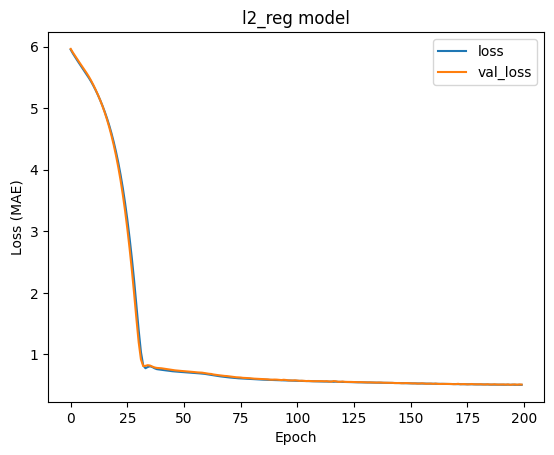

In [46]:
plot_history('l2_reg',history)
# plt.ylim([0,1])

#### Dropout
El *dropout* es una de las técnicas de regularización de redes neuronales más eficaces y utilizadas, que consiste en «descartar» aleatoriamente una serie de características de salida de la capa durante el entrenamiento. Por ejemplo, una capa determinada habría devuelto normalmente un vector `[0,2, 0,5, 1,3, 0,8, 1,1]` para una muestra de entrada determinada durante el entrenamiento; después de aplicar el dropout, este vector tendrá unas cuantas entradas cero distribuidas al azar, por ejemplo `[0, 0,5, 1,3, 0, 1,1]`.

El *dropout rate* es la fracción de las características que se eliminan; normalmente se fija entre 0,2 y 0,5. 

En TensorFlow, puedes introducir el abandono en una red a través de la capa `tf.keras.layers.Dropout`, que se aplica a la salida de la capa justo antes.

In [41]:
dropout_model = tf.keras.Sequential([
    layers.Input(shape=[X_train.shape[1]]),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1),
])

history = compile_and_fit(l2_model, [])

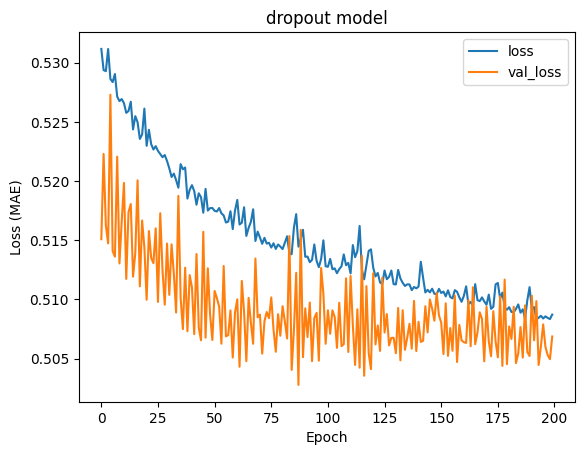

In [42]:
plot_history('dropout',history)
# plt.ylim([])

## Conlcusiones
Para recapitular, éstas son las formas más comunes de evitar el sobreajuste en las redes neuronales:

* Obtener más datos de entrenamiento.
* Reducir la capacidad de la red.
* Añadir regularización de pesos.
* Añadir abandono.